# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re
from sklearn.linear_model import LogisticRegression

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


In [2]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [3]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

# Import data

In [4]:
#Using polar to read the data since it is faster than pandas for large data
data=pd.read_csv('/Users/abdul/Desktop/machine learning/data/home-data-for-ml-course/NLP/amazon_alexa.tsv'
                 , delimiter = '\t', quoting = 3)
data.head(5)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


# Quick EDA

## Shape of data and missing

In [5]:
print(data.shape)
df=data.copy()

(3150, 5)


In [6]:
# checking for missing values
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [7]:
# Checking for missing values
df[df['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [8]:
# Dropping missing values
df.dropna(inplace=True)
df.shape

(3149, 5)

In [9]:
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

## Analyzing rating variable 

Text(0.5, 0, 'rating rating')

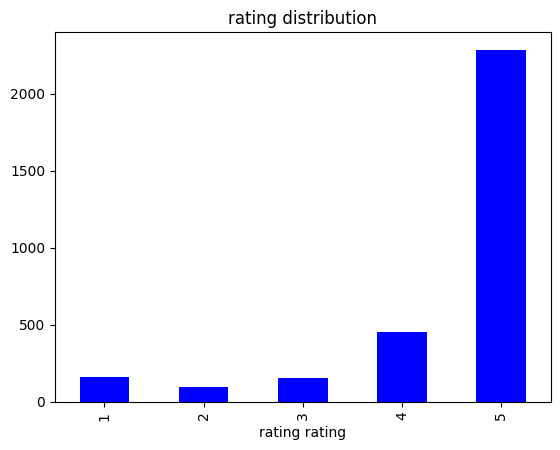

In [10]:
ax=df['rating'].value_counts().sort_index().plot(kind='bar',color='blue',title='rating distribution')
ax.set_xlabel('rating rating')

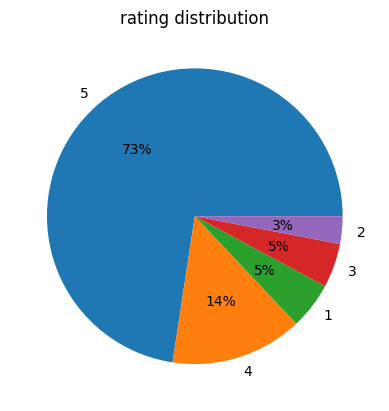

In [11]:
ax=plt.pie(df['rating'].value_counts(), labels=df['rating'].value_counts().index, autopct='%.0f%%') 
ax=plt.title('rating distribution') 
# displaying chart 
plt.show() 

In [12]:
df['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

We see that the score it is not uniform, we have more good grade than bad. We can assume in the dataset we will have more good sentiments.

In [13]:
# let's create a new column containing the length of the text
df['Text_length']=df['verified_reviews'].apply(len)
df.head(3)

,rating,date,variation,verified_reviews,feedback,Text_length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197


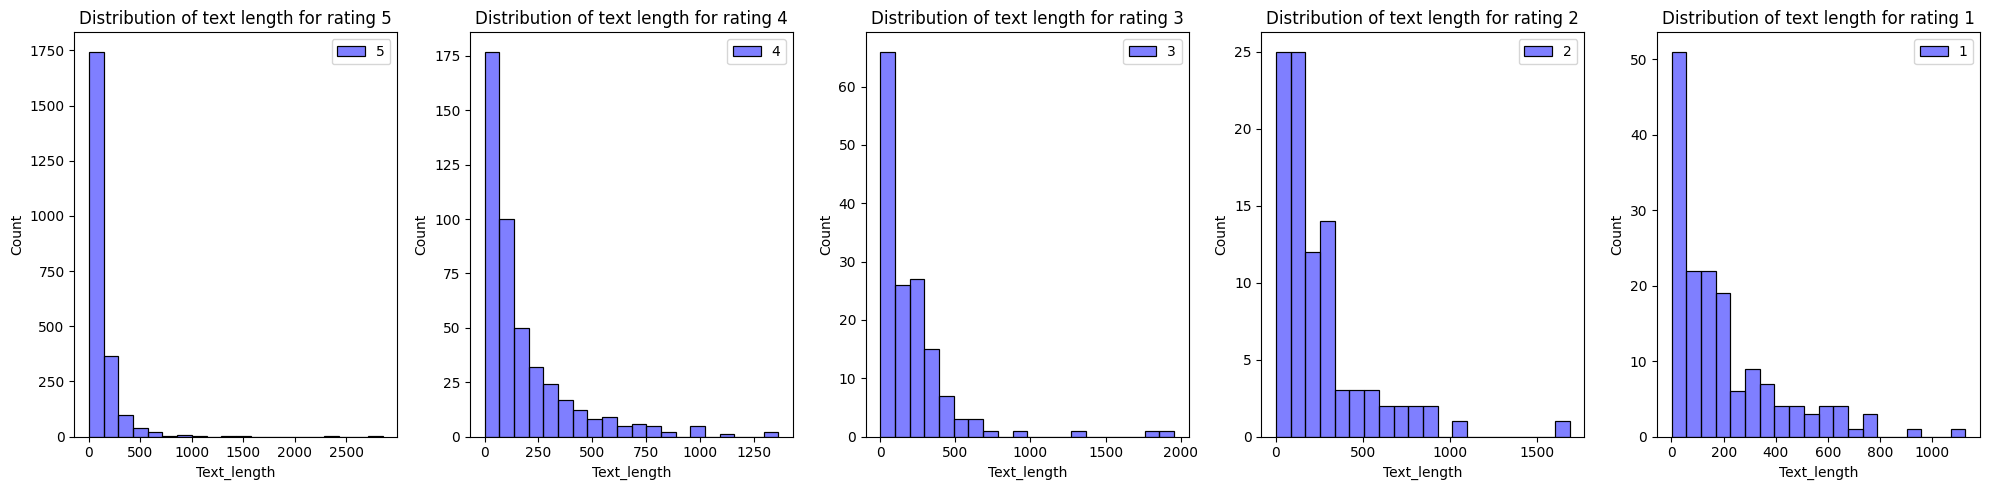

In [14]:
# Distribution of text length by rating
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

for i, rating in enumerate(df['rating'].unique()):
    sns.histplot(df[df['rating']==rating]['Text_length'], bins=20, color='blue', label=rating, alpha=0.5, ax=ax[i])
    ax[i].set_title(f'Distribution of text length for rating {rating}')
    ax[i].legend()

plt.tight_layout()
plt.show()

Rating 1 and 2 share a similar distribution. Rating 3 et 4 share a similar distribution.
Rating 5 have the shortest comments of all reviews.

## Analyzing feedback variable 

In [15]:
df['feedback'].value_counts()/len(df)

feedback
1    0.918704
0    0.081296
Name: count, dtype: float64

In [16]:
# Distribution of feedback by rating
print(data[data['feedback'] == 0]['rating'].value_counts())
print(data[data['feedback'] == 1]['rating'].value_counts())

rating
1    161
2     96
Name: count, dtype: int64
rating
5    2286
4     455
3     152
Name: count, dtype: int64


1 = positive feedback (rating 3,4,5)
2 = negative feedback (rating 1,2)

<Axes: xlabel='feedback', ylabel='count'>

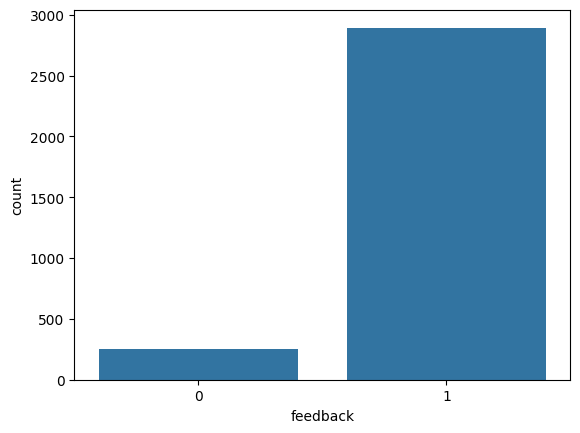

In [17]:
sns.barplot(df['feedback'].value_counts())

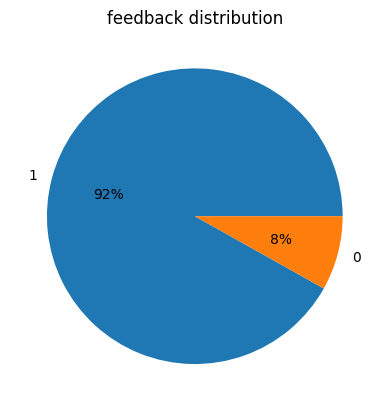

In [18]:
ax=plt.pie(df['feedback'].value_counts(), labels=df['feedback'].value_counts().index, autopct='%.0f%%') 
ax=plt.title('feedback distribution') 
# displaying chart 
plt.show() 

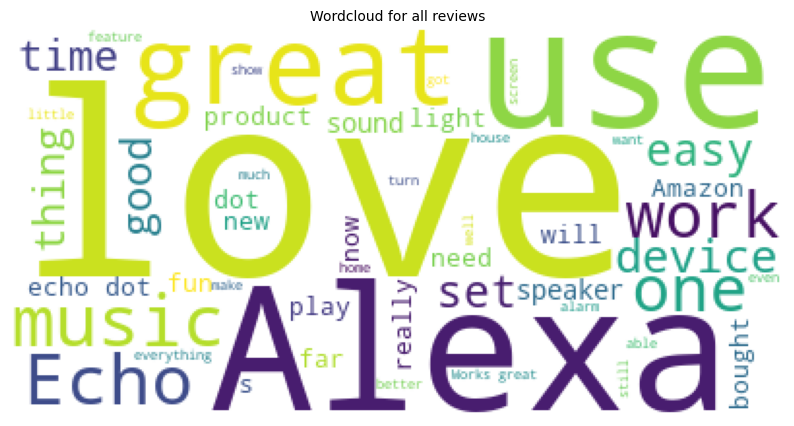

In [19]:
# Visualizing the distribution of text length with wordcloud with all data
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.verified_reviews)
# Combine all reviews
reviews = " ".join([review for review in df['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

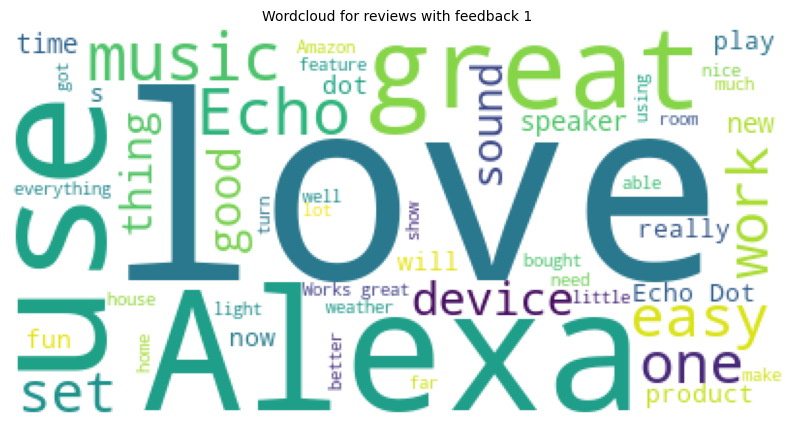

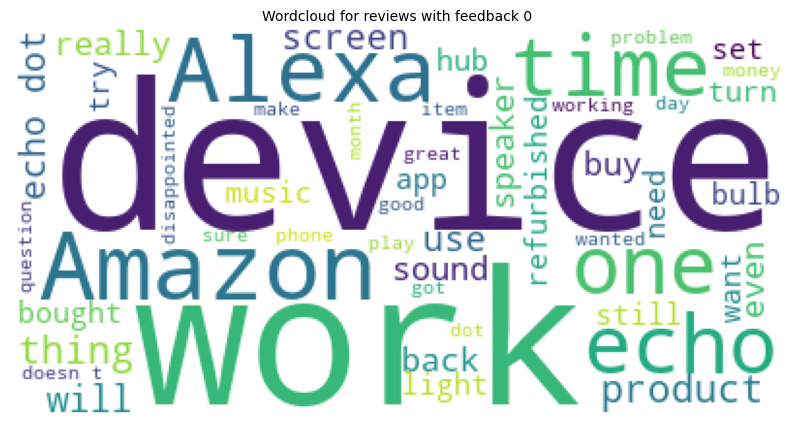

In [20]:
# Vizualizing the distribution of text length with wordcloud by feedback
cv = CountVectorizer(stop_words='english')
for feedback in df['feedback'].unique():
    # Combine all reviews
    reviews = " ".join([review for review in df[df['feedback']==feedback]['verified_reviews']])
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', max_words=50)
    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(reviews))
    plt.title(f'Wordcloud for reviews with feedback {feedback}', fontsize=10)
    plt.axis('off')
    plt.show()

# Pre-processing and modelling

In [21]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, df.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [22]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = df['verified_reviews'].values

In [29]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2519, 2500)
y train: (2519,)
X test: (630, 2500)
y test: (630,)


In [25]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 7


In [30]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [31]:
# Import of libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from xgboost import XGBClassifier

In [34]:
# Define model to test
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'Xgboost': XGBClassifier()
}

# Parameter grinds for each model
param_grids = {

    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2']
    },
    'Xgboost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.2,0.05, 0.01],
        'max_depth': [3, 5, 7],
    }
}

In [35]:
results = {}
for model_name, model in models.items():
    param_grid = param_grids[model_name]
    
    grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)
    
    accuracy = grid_search.score(X_test, y_test)
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'test_accuracy': accuracy
    }
    print(f"Classifier: {model_name}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_}")
    print(f"Test accuracy: {accuracy}")
    print("----------------------------------------")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
